# Import libraries 

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import glob

import requests
from PIL import Image
from io import BytesIO

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax

%matplotlib inline

In [35]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import GridSearchCV

# Data preparation (binary classification)

## let's have a look at images 

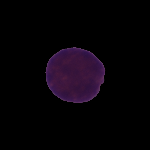

In [36]:
path = '/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data'
name = '1000.bmp'
fullname = f'{path}/{name}'
img = load_img(fullname, target_size=(150, 150))
img

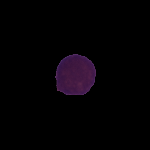

In [37]:
path = '/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data'
name = '1005.bmp'
fullname = f'{path}/{name}'
img = load_img(fullname, target_size=(150, 150))
img

## Now we prepare the images - scale them (1./255) and shrink to (150, 150) size

In [38]:
train_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    '/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_0/',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,  class_mode='binary'
)

Found 3527 images belonging to 2 classes.


In [39]:
val_gen = ImageDataGenerator(rescale=1./255)

val_ds = val_gen.flow_from_directory(
    '/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_1/',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,  class_mode='binary'
)

Found 3581 images belonging to 2 classes.


In [40]:
test_gen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=50,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')

test_ds = test_gen.flow_from_directory(
    '/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,  class_mode='binary'
)

Found 3553 images belonging to 2 classes.


# Model 1: simple convolutional neural network

In [44]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=0.002, momentum=0.8),\
             metrics=['acc'])

In [45]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10
177/177 [==============================] - 36s 203ms/step - loss: 0.4780 - acc: 0.7874 - val_loss: 0.4010 - val_acc: 0.8350
Epoch 2/10
177/177 [==============================] - 36s 204ms/step - loss: 0.4371 - acc: 0.8214 - val_loss: 0.4232 - val_acc: 0.8308
Epoch 3/10
177/177 [==============================] - 38s 214ms/step - loss: 0.4347 - acc: 0.8191 - val_loss: 0.4012 - val_acc: 0.8266
Epoch 4/10
177/177 [==============================] - 39s 221ms/step - loss: 0.4269 - acc: 0.8208 - val_loss: 0.4284 - val_acc: 0.8257
Epoch 5/10
177/177 [==============================] - 37s 211ms/step - loss: 0.4298 - acc: 0.8174 - val_loss: 0.3982 - val_acc: 0.8311
Epoch 6/10
177/177 [==============================] - 38s 216ms/step - loss: 0.4234 - acc: 0.8211 - val_loss: 0.3997 - val_acc: 0.8283
Epoch 7/10
177/177 [==============================] - 38s 214ms/step - loss: 0.4222 - acc: 0.8236 - val_loss: 0.4110 - val_acc: 0.8294
Epoch 8/10
177/177 [==============================] - 3

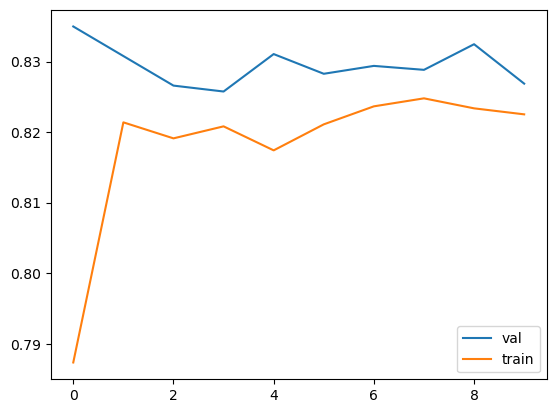

In [66]:
hist = history.history
plt.plot(hist['val_acc'], label='val')
plt.plot(hist['acc'], label='train')

plt.legend()

In [67]:
train_ds.class_indices

{'all': 0, 'hem': 1}

In [68]:
model.metrics_names

['loss', 'acc']

In [65]:
# loss and accuracy 
# model.metrics_names
model.evaluate(test_ds)

178/178 [==============================] - 46s 261ms/step - loss: 0.6352 - acc: 0.6513


[0.6351622939109802, 0.6512805819511414]

In [71]:
# HEM
sample_path = 'https://raw.githubusercontent.com/triasteran/Machine-Learning-Zoomcamp-2023/b9f4faf7b04311b191b7fa12ab3fedabf9825d69/CapstoneProject1/tests/UID_h3_6_1_hem.bmp'
    
response = requests.get(sample_path)   

img = Image.open(BytesIO(response.content)).resize((150, 150),Image.NEAREST)


# preprocess it 
x = np.array(img, dtype='float32')
X = np.array([x])
X = X/ (1./255)

# now use the model to predict a class 
pred = model.predict(X)[0]

res = {'hem':pred[0], 'all':1-pred[0]}

res

1/1 [==============================] - 0s 27ms/step


{'hem': 0.0, 'all': 1.0}

In [72]:
# ALL
sample_path = 'https://raw.githubusercontent.com/triasteran/Machine-Learning-Zoomcamp-2023/b9f4faf7b04311b191b7fa12ab3fedabf9825d69/CapstoneProject1/tests/UID_78_9_7_all.bmp'
    
response = requests.get(sample_path)   

img = Image.open(BytesIO(response.content)).resize((150, 150),Image.NEAREST)


# preprocess it 
x = np.array(img, dtype='float32')
X = np.array([x])
X = X/255

# now use the model to predict a class 
pred = model.predict(X)[0]

res = {'hem':pred[0], 'all':1-pred[0]}

res

1/1 [==============================] - 0s 32ms/step


{'hem': 0.051099427, 'all': 0.9489005729556084}

In [60]:
!# ls /home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/all

In [73]:
main_path = '/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/'
hem_test = main_path + '/' + 'hem/'+ 'UID_H1_25_1_hem.bmp'
all_test = main_path + '/' + 'all/'+ 'UID_67_16_4_all.bmp'

In [74]:
def preprocess_input(x):
    x /= 1./255
    return x

with Image.open(hem_test) as img:
    img = img.resize((150, 150), Image.NEAREST)

x = np.array(img, dtype='float32')
X = np.array([x])

X = preprocess_input(X)

pred = model.predict(X)[0]

# HEM prob 

res = {'hem':pred[0], 'all':1-pred[0]}

res

1/1 [==============================] - 0s 19ms/step


{'hem': 1.0, 'all': 0.0}

In [75]:
with Image.open(all_test) as img:
    img = img.resize((150, 150), Image.NEAREST)

x = np.array(img, dtype='float32')
X = np.array([x])

X = preprocess_input(X)

pred = model.predict(X)[0]

res = {'hem':pred[0], 'all':1-pred[0]}

res

1/1 [==============================] - 0s 26ms/step


{'hem': 0.0, 'all': 1.0}

# Model1: adjusting learning rate 

In [76]:
def create_CNN_model(learning_rate = 0.001):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))

    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8),
             metrics=['acc'])
    
    return model

In [77]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = create_CNN_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
177/177 [==============================] - 40s 225ms/step - loss: 0.5848 - acc: 0.6756 - val_loss: 0.5232 - val_acc: 0.6752
Epoch 2/10
177/177 [==============================] - 41s 228ms/step - loss: 0.5230 - acc: 0.6932 - val_loss: 0.4815 - val_acc: 0.7738
Epoch 3/10
177/177 [==============================] - 40s 224ms/step - loss: 0.4934 - acc: 0.7888 - val_loss: 0.4532 - val_acc: 0.8168
Epoch 4/10
177/177 [==============================] - 40s 224ms/step - loss: 0.4736 - acc: 0.8149 - val_loss: 0.4369 - val_acc: 0.8257
Epoch 5/10
177/177 [==============================] - 41s 231ms/step - loss: 0.4616 - acc: 0.8225 - val_loss: 0.4249 - val_acc: 0.8319
Epoch 6/10
177/177 [==============================] - 40s 224ms/step - loss: 0.4539 - acc: 0.8205 - val_loss: 0.4205 - val_acc: 0.8308
Epoch 7/10
177/177 [==============================] - 41s 230ms/step - loss: 0.4488 - acc: 0.8202 - val_loss: 0.4129 - val_acc: 0.8338
Epoch 8/10
177/177 [============================

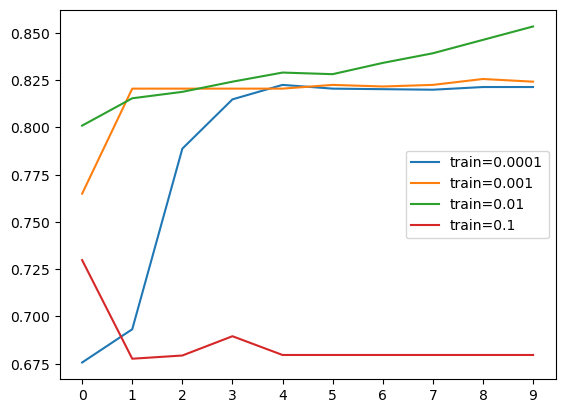

In [79]:
for lr, hist in scores.items():
    plt.plot(hist['acc'], label=('train=%s' % lr))
    #plt.plot(hist['val_accuracy'], label=('test=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

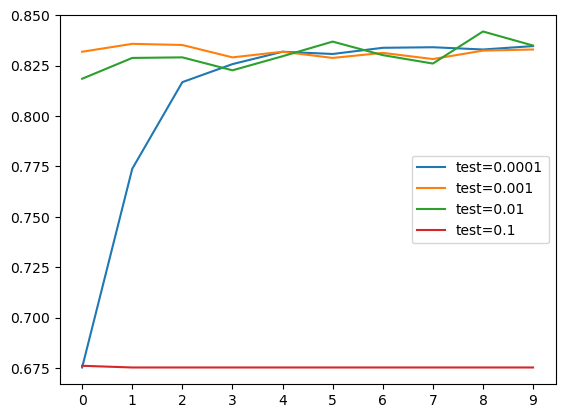

In [80]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_acc'], label=('test=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()


# Advancing Model1: dropout

In [81]:
def create_CNN_model_advanced(learning_rate = 0.01,  droprate=0.5):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))

    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))

    model.add(Dropout(droprate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8),
             metrics=['acc'])
    
    return model

In [82]:
learning_rate = 0.01

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = create_CNN_model_advanced(learning_rate = learning_rate,  
                                      droprate=droprate)

    history = model.fit(train_ds, epochs=10, validation_data=test_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/10
177/177 [==============================] - 70s 394ms/step - loss: 0.4725 - acc: 0.7959 - val_loss: 0.5878 - val_acc: 0.7152
Epoch 2/10
177/177 [==============================] - 70s 399ms/step - loss: 0.4436 - acc: 0.8185 - val_loss: 0.5750 - val_acc: 0.7239
Epoch 3/10
177/177 [==============================] - 68s 388ms/step - loss: 0.4326 - acc: 0.8197 - val_loss: 0.6000 - val_acc: 0.6741
Epoch 4/10
177/177 [==============================] - 68s 383ms/step - loss: 0.4247 - acc: 0.8197 - val_loss: 0.5947 - val_acc: 0.6721
Epoch 5/10
177/177 [==============================] - 68s 384ms/step - loss: 0.4216 - acc: 0.8239 - val_loss: 0.5989 - val_acc: 0.6730
Epoch 6/10
177/177 [==============================] - 68s 384ms/step - loss: 0.4097 - acc: 0.8276 - val_loss: 0.6028 - val_acc: 0.6834
Epoch 7/10
177/177 [==============================] - 69s 389ms/step - loss: 0.4006 - acc: 0.8373 - val_loss: 0.6347 - val_acc: 0.6487
Epoch 8/10
177/177 [==============================]

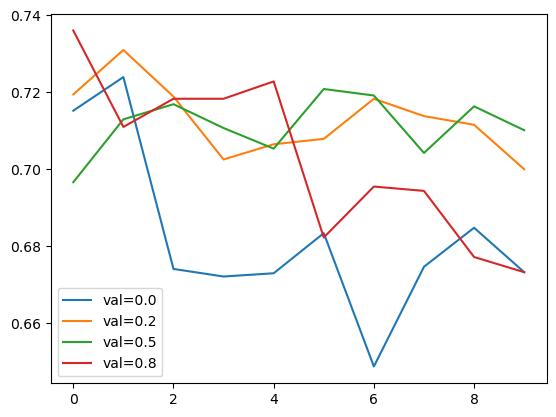

In [85]:
for droprate, hist in scores.items():
    plt.plot(hist['val_acc'], label=('val=%s' % droprate))

#plt.ylim(0.78, 0.86)
plt.legend()

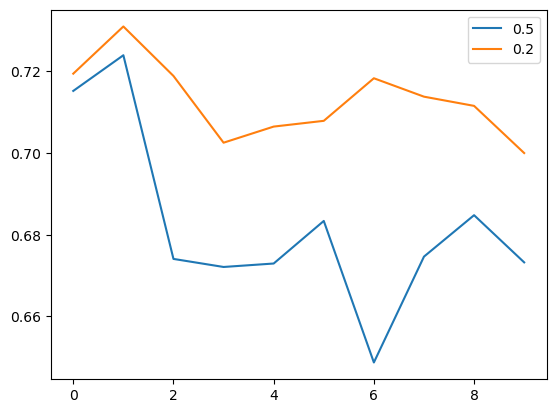

In [87]:
hist = scores[0.0]
plt.plot(hist['val_acc'], label=0.5)

hist = scores[0.2]
plt.plot(hist['val_acc'], label=0.2)

plt.legend()
#plt.plot(hist['accuracy'], label=('val=%s' % droprate))

# Advancing Model1 further: data augmentation

In [88]:
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=50,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

train_ds = train_gen.flow_from_directory(
    '/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_0/',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,  class_mode='binary'
)

val_gen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=50,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')

val_ds = val_gen.flow_from_directory(
    '/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_1/',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,  class_mode='binary'
)

Found 3527 images belonging to 2 classes.
Found 3581 images belonging to 2 classes.


In [89]:
learning_rate = 0.001
droprate = 0.2

model = create_CNN_model_advanced(learning_rate = learning_rate,  
                                  droprate=droprate)

history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
177/177 [==============================] - 95s 539ms/step - loss: 0.5690 - acc: 0.6856 - val_loss: 0.5076 - val_acc: 0.7230
Epoch 2/10
177/177 [==============================] - 99s 563ms/step - loss: 0.5155 - acc: 0.7587 - val_loss: 0.4603 - val_acc: 0.8023
Epoch 3/10
177/177 [==============================] - 99s 559ms/step - loss: 0.5003 - acc: 0.7882 - val_loss: 0.4563 - val_acc: 0.7998
Epoch 4/10
177/177 [==============================] - 101s 571ms/step - loss: 0.4890 - acc: 0.7874 - val_loss: 0.4395 - val_acc: 0.8199
Epoch 5/10
177/177 [==============================] - 101s 570ms/step - loss: 0.4826 - acc: 0.7896 - val_loss: 0.4335 - val_acc: 0.8129
Epoch 6/10
177/177 [==============================] - 102s 578ms/step - loss: 0.4791 - acc: 0.7959 - val_loss: 0.4406 - val_acc: 0.8132
Epoch 7/10
177/177 [==============================] - 101s 570ms/step - loss: 0.4687 - acc: 0.8049 - val_loss: 0.4208 - val_acc: 0.8244
Epoch 8/10
177/177 [==============================]

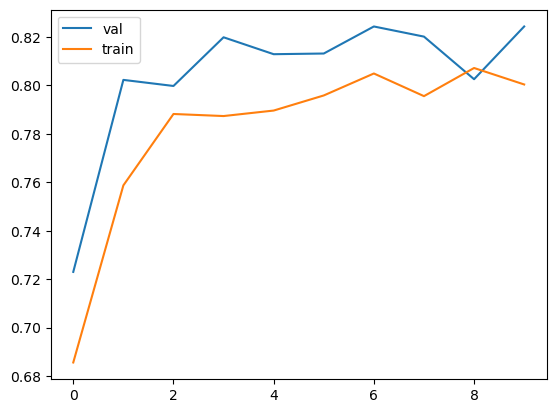

In [90]:
hist = history.history
plt.plot(hist['val_acc'], label='val')
plt.plot(hist['acc'], label='train')

plt.legend()

# Finally we save the best model via checkpointing. We will use the simpler version with chosen droprate and learning rate, but no augmentation this time

In [93]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'cnn_v1_{epoch:02d}_{val_acc:.3f}.h5',
    save_best_only=True,
    monitor='val_acc',
    mode='max'
)

In [94]:
learning_rate = 0.001
droprate = 0.2

model = create_CNN_model_advanced(learning_rate = learning_rate,  
                                  droprate=droprate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/10
177/177 [==============================] - 103s 580ms/step - loss: 0.5671 - acc: 0.6844 - val_loss: 0.5074 - val_acc: 0.7154
Epoch 2/10
177/177 [==============================] - 104s 587ms/step - loss: 0.5140 - acc: 0.7516 - val_loss: 0.4705 - val_acc: 0.8109
Epoch 3/10
177/177 [==============================] - 102s 576ms/step - loss: 0.4942 - acc: 0.7899 - val_loss: 0.4451 - val_acc: 0.8160
Epoch 4/10
177/177 [==============================] - 104s 589ms/step - loss: 0.4914 - acc: 0.7973 - val_loss: 0.4402 - val_acc: 0.8154
Epoch 5/10
177/177 [==============================] - 102s 577ms/step - loss: 0.4804 - acc: 0.7913 - val_loss: 0.4296 - val_acc: 0.8238
Epoch 6/10
177/177 [==============================] - 103s 586ms/step - loss: 0.4803 - acc: 0.8010 - val_loss: 0.4260 - val_acc: 0.8230
Epoch 7/10
177/177 [==============================] - 104s 590ms/step - loss: 0.4796 - acc: 0.7959 - val_loss: 0.4347 - val_acc: 0.8132
Epoch 8/10
177/177 [============================

# Now we can evaluate and use the model

In [96]:
model = keras.models.load_model('cnn_v1_10_0.825.h5') 

In [121]:
# loss and accuracy 
# model.metrics_names
out = model.evaluate(test_ds)

loss, test_acc = out

print (test_acc)

178/178 [==============================] - 42s 238ms/step - loss: 0.5316 - acc: 0.7498
0.7497889399528503


I just found out that there is a significant class imbalance and 'all' samples are predicted much better than 'hem' unfortunately 

In [143]:
counter = {'hem':0, 'all':0}

path = '/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/hem/'

for fullname in glob.glob(path+'*'):
    img = load_img(fullname, target_size=(150, 150))
    x = np.array(img, dtype='float32')
    X = np.array([x])
    X = X/ 255
    
    pred = model.predict(X)[0]
    res = {'hem':pred[0], 'all':1-pred[0]}
    #print (res)

    if pred >= 0.5:
        counter['hem'] += 1
        print (fullname)
    else:
        counter['all'] += 1


counter['hem'] / (counter['hem'] + counter['all'])

1/1 [==============================] - 0s 30ms/step
/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/hem/UID_H48_16_13_hem.bmp
1/1 [==============================] - 0s 32ms/step
/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/hem/UID_H23_9_14_hem.bmp
1/1 [==============================] - 0s 23ms/step
/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/hem/UID_H23_13_1_hem.bmp
1/1 [==============================] - 0s 44ms/step
/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/hem/UID_H23_14_8_hem.bmp
1/1 [==============================] - 0s 46ms/step
/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/hem/UID_H23_23_9_hem.bmp
1/1 [==============================] - 0s 37ms/step
/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/hem/UID_H13_30_3_hem.bmp
1/1 [==============================] - 0s 36ms/step
/home/alla/ML/CapstoneProject1/arch

KeyboardInterrupt: 

In [134]:
counter

{'hem': 446, 'all': 650}

In [142]:
counter = {'hem':0, 'all':0}

path = '/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/all/'

for fullname in glob.glob(path+'*'):
    img = load_img(fullname, target_size=(150, 150))
    x = np.array(img, dtype='float32')
    X = np.array([x])
    X = X/ 255
    
    pred = model.predict(X)[0]
    res = {'hem':pred[0], 'all':1-pred[0]}
    #print (res)

    if pred >= 0.5:
        counter['hem'] += 1
        
    else:
        counter['all'] += 1


counter['hem'] / (counter['hem'] + counter['all'])

1/1 [==============================] - 0s 32ms/step
/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/all/UID_25_21_2_all.bmp
1/1 [==============================] - 0s 50ms/step
/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/all/UID_24_21_1_all.bmp
1/1 [==============================] - 0s 26ms/step
/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/all/UID_37_23_4_all.bmp
1/1 [==============================] - 0s 57ms/step
/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/all/UID_24_8_8_all.bmp
1/1 [==============================] - 0s 57ms/step
/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/all/UID_27_10_5_all.bmp
1/1 [==============================] - 0s 63ms/step
/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_2/all/UID_37_18_5_all.bmp
1/1 [==============================] - 0s 75ms/step
/home/alla/ML/CapstoneProject1/archive/C-NM

KeyboardInterrupt: 

In [136]:
counter

{'hem': 201, 'all': 2256}

In [137]:
# {'hem': 446, 'all': 650}
correct_pred = 446 + 2256
total = 446 + 650 + 2256 + 201

correct_pred / total 

0.7604840979453983

Let's quickly check whether our model will predict images that I put to my github 

In [139]:
# ALL
sample_path = 'https://raw.githubusercontent.com/triasteran/Machine-Learning-Zoomcamp-2023/b9f4faf7b04311b191b7fa12ab3fedabf9825d69/CapstoneProject1/tests/UID_78_9_7_all.bmp'
    
response = requests.get(sample_path)   

img = Image.open(BytesIO(response.content)).resize((150, 150),Image.NEAREST)


# preprocess it 
x = np.array(img, dtype='float32')
X = np.array([x])
X = X/ 255

# now use the model to predict a class 
pred = model.predict(X)[0]

res = {'hem':pred[0], 'all':1-pred[0]}

# it's 'all' 
res

1/1 [==============================] - 0s 20ms/step


{'hem': 0.08117297, 'all': 0.9188270270824432}

In [140]:
# HEM
sample_path = 'https://raw.githubusercontent.com/triasteran/Machine-Learning-Zoomcamp-2023/b9f4faf7b04311b191b7fa12ab3fedabf9825d69/CapstoneProject1/tests/UID_h3_6_1_hem.bmp'
    
response = requests.get(sample_path)   

img = Image.open(BytesIO(response.content)).resize((150, 150),Image.NEAREST)


# preprocess it 
x = np.array(img, dtype='float32')
X = np.array([x])
X = X/ 255

# now use the model to predict a class 
pred = model.predict(X)[0]

# it's unfortunetely 'all' too due to class imbalance 
res = {'hem':pred[0], 'all':1-pred[0]}
res

1/1 [==============================] - 0s 19ms/step


{'hem': 0.09328697, 'all': 0.906713031232357}

# Let's have a quick look at pretrained models 

## Model2: EfficientNet. it takes quite some time to train! and val_accuracy is not impressive

In [43]:
EfficientNetBaseModel = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, 
                                                                   weights= "imagenet", 
                                                                   input_shape= (150, 150, 3), 
                                                                   pooling= 'max')

EfficientNetModel = Sequential([
    EfficientNetBaseModel,
    BatchNormalization(),  
    Dense(256, activation='relu'), 
    Dropout(0.45),
    Dense(1, activation='sigmoid')
])

# Compile the model
EfficientNetModel.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

EfficientNetModel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_4 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               393472    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 11,183,408
Trainable params: 11,093,033
Non-trainable params: 90,375
_____________________________________

In [ ]:
EfficientNetModel_history = EfficientNetModel.fit(x = train_ds, 
                            epochs = 6, 
                            verbose = 1,
                            validation_data = val_ds)

Epoch 1/6
177/177 [==============================] - 615s 3s/step - loss: 0.5020 - accuracy: 0.8081 - val_loss: 0.6513 - val_accuracy: 0.6752
Epoch 2/6
177/177 [==============================] - 670s 4s/step - loss: 0.3644 - accuracy: 0.8625 - val_loss: 0.5531 - val_accuracy: 0.7476
Epoch 3/6
177/177 [==============================] - 669s 4s/step - loss: 0.2800 - accuracy: 0.8903 - val_loss: 0.6829 - val_accuracy: 0.6752
Epoch 4/6
177/177 [==============================] - 717s 4s/step - loss: 0.2190 - accuracy: 0.9181 - val_loss: 10.3655 - val_accuracy: 0.6627
Epoch 5/6
177/177 [==============================] - 675s 4s/step - loss: 0.1518 - accuracy: 0.9379 - val_loss: 0.6137 - val_accuracy: 0.6758
Epoch 6/6
 37/177 [=====>........................] - ETA: 7:15 - loss: 0.1688 - accuracy: 0.9203

In [ ]:
hist = EfficientNetModel_history.history
plt.plot(hist['val_acc'], label='val')
plt.plot(hist['acc'], label='train')

plt.legend()

validation accuracy does not look very good 

## Model3: VGG16,val acc is not impressive either

In [ ]:
# Instantiate base model
VGG16BaseModel = VGG16(weights='imagenet', 
                         input_shape=(150,150,3), 
                         include_top=False, 
                         pooling=None)

# we need to keep pre-trained weights 
VGG16BaseModel.trainable = False

# adding layers on top for bindary classification 
last_layer = VGG16_base_model.get_layer('block5_pool')
last_output = last_layer.output
x = keras.layers.GlobalMaxPooling2D()(last_output)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x) 

# Create new model
VGG16Model = tf.keras.Model(VGG16BaseModel.input, x, name="VGG16Model")

VGG16Model.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

VGG16Model.summary()

In [ ]:
history_VGG16 = VGG16Model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    verbose=1
)

In [ ]:
hist = history_VGG16 .history
plt.plot(hist['val_acc'], label='val')
plt.plot(hist['acc'], label='train')

plt.legend()

# Let's try other non-NN models 

## Model4: Random Forest 

### prepare train and validation sets 

In [15]:
X_train  = []
y_train = []

for classes in ['all', 'hem']:
    for path in glob.glob('/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_0/%s/*' % classes):
        y_train.append(classes)

        img = np.array(load_img(path, target_size=(150, 150))).flatten()
        X_train.append(img)


y_train = np.array(list(map({'all':1, 'hem':1}.get, y_train)))
X_train = np.array(X_train)

X_val  = []
y_val = []

for classes in ['all', 'hem']:
    for path in glob.glob('/home/alla/ML/CapstoneProject1/archive/C-NMC_Leukemia/training_data/fold_1/%s/*' % classes):
        y_val.append(classes)

        img = np.array(load_img(path, target_size=(150, 150))).flatten()
        X_val.append(img)


y_val = np.array(list(map({'all':1, 'hem':0}.get, y_val)))
X_val = np.array(X_val)

In [16]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((3527, 67500), (3527,), (3581, 67500), (3581,))

### tune params

In [17]:
param_grid_rf = { 
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8]}

RF_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv= 5)
RF_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [18]:
print(RF_grid.best_params_)

{'max_depth': 4, 'n_estimators': 200}


In [ ]:
### use the model 

In [19]:
r_forest = RandomForestClassifier(200,max_depth=4, random_state=5)
r_forest.fit(X_train,y_train)

predicted = r_forest.predict(X_val)
score = r_forest.score(X_val, y_val)
rf_score_ = np.mean(score)

print('Accuracy : %.3f' % (rf_score_))

Accuracy : 0.675


In [21]:
p=precision_score(y_val, predicted) 
print('precision : %.3f' % (p))

r=recall_score(y_val, predicted) 
print('recall : %.3f' % (r))

f1=f1_score(y_val, predicted) 
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_val, predicted, average='weighted') 
print('weighted f1-score: %.3f' % (f1_w))

precision : 0.675
recall : 1.000
f1-score: 0.806
weighted f1-score: 0.544


## Model5: Naive Bayes 

In [23]:
nb_model = GaussianNB()
nb_model.fit(X_train,y_train)

predicted = nb_model.predict(X_val)
score = nb_model.score(X_val, y_val)
nb_score_ = np.mean(score)

print('Accuracy : %.3f' % (nb_score_))

Accuracy : 0.675
